# Tutorial 4: Running the model on downscaled climate projections

### Outline:

* Imports, including library code from previous steps
* Loading the trained model
* Opening and browsing the downscaled CMIP6 data
* Running the projections through the model
* Analysis

## Setup and configuration

At this point you should be familiar with the setup routine, importing packages and setting devices and datatypes.

In [1]:
import os
import torch
import intake
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings

from tqdm.autonotebook import tqdm
from matplotlib.colors import PowerNorm

from src.datapipes import (
    get_static_data, 
    select_region, 
    make_data_pipeline, 
    scale_means, 
    scale_stds
)
from src.utils import load_experiment
from src.models import create_lstm_model
from src.inference import run_model

warnings.filterwarnings('ignore')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float16

/tmp/ipykernel_25387/3060137355.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Getting the model imported and loaded up

Just as we did in the previous portion of the tutorial, we will use the experiment file to load in our hyperparameters and settings. From there we can use the `create_lstm_model` to construct the structure. Next we load the weights, and set the device and data type appropriately. Finally, we set the model to evaluation mode.

In [2]:
config_file = '../experiments/tutorial/tutorial.yml'
config = load_experiment(config_file)
model = create_lstm_model(**config['model_config'])
model.load_state_dict(torch.load(config['weights_file'], map_location=DEVICE))
model.to(DEVICE).to(DTYPE)
model.eval()

Sequential(
  (0): LSTM(5, 128, batch_first=True)
  (1): LSTMOutput()
  (2): Linear(in_features=128, out_features=1, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
)

## Data preparation

Unfortunately, we still also have a bit of work to do to make the climate projections usable with our model. Now that we're running in forward mode on completely new data it's worth seeing what everything looks like. As you can see after opening up the catalog, the data has a similar overall structure as the ERA5 data, but with some additional keys. These correspond to the different emission pathways (experiments), global climate models, and downscaling methods that were used to produce CarbonPlan's downscaled CMIP6 ensemble. For more details see the [CarbonPlan Data Explorer](https://carbonplan.org/research/cmip6-downscaling?t=2015-1-1&f=7b2273223a227373703234352c7373703337302c737370353835222c2276223a227461736d6178222c2274223a2279656172227d&active=ScenarioMIP.CCCma.CanESM5.ssp245.r1i1p1f1.day.GARD-SV.tasmax.year).

In [3]:
cat = intake.open_esm_datastore(
  'https://cpdataeuwest.blob.core.windows.net/cp-cmip/version1/catalogs/global-downscaled-cmip6.json'
)
cat

,unique
activity_id,2
institution_id,7
source_id,6
experiment_id,4
member_id,1
timescale,3
variable_id,3
method,5
downscaled_daily_data_uri,339
version,1


We can just grab a single ensemble member using some arbitrary choices for the downscaling method (`method`), CanESM5 as the GCM (`source_id`), and SSP 245 scenario (`experiment_id`). As before, we want data with the daily minimum temperature, daily maximum temperature, and precipitation at a daily timescale. To see the available options you can either use the CarbonPlan Data Explorer, or use the catalog to find options for each of the settings like we did in the first part of tutorial with the ERA5 catalog.

In [4]:
cat_subset = cat.search(
    method="GARD-SV",
    source_id="CanESM5",
    experiment_id="ssp245",
    variable_id=['tasmin', 'tasmax', 'pr'],
    timescale='day',
)
dsets = cat_subset.to_dataset_dict()
met_ds = list(dsets.values())[0]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.timescale.method'


Next we can open up the static data, which contains the elevation, slopes, aspects, and mask variables. These are actually on a slightly different grid than the CMIP6 data - basically the static data just has longitudes that go from 0 to 360, and the CMIP6 data has longitudes from -180 to 180. Otherwise the grids are identical, which makes it easy to line them back up. To do that we just roll the longitude dimension by half of the total number of gridcells. We will assign the correct coordinates simply using the `assign_coords` method and set the new longitudes using CMIP6 data we just opened up. And then finally we can merge it all into a single `ds`.

In [5]:
static_data = get_static_data()
static_data = static_data.roll(lon=720)
static_data = static_data.assign_coords({'lon': met_ds['lon']})
ds = xr.merge([met_ds.squeeze(), static_data])

You may note that the given `ds` here is still the global data, so now we use the `select_region` method to clip out just the region(s) that we specified in the configuration. Next, is another preprocessing step for making the CMIP6 data match the ERA5 training data by scaling the precipitation from mm/day to mm/second. This is a simple division by the number of seconds in a day, 86400. Then, we copy out the mask just like we did in the previous section of the tutorial and set the mask in the test data to be all ones so we can run the forward mode on the full domain all at once. We also add the cubed root of precipitation to the dataset so that we match the training data. And finally, as little bit of a workaround to the data pipeline, we set the output variables to just be `cbrt_pr`, since we don't actually have the `swe` as a variable (if we did, then we wouldn't need this project after all!). This just ends up being a "dummy" output that we will not actually use.

In [6]:
test_data = select_region(ds, config['data_config']['regions'])
# Need to convert from mm/day to mm/s to match ERA5
test_data['pr'] = test_data['pr'] / 86400
test_data['cbrt_pr'] = np.power(test_data['pr'], 1/3)
config['data_config']['output_vars'] = ['cbrt_pr']

Next up, we just have to perform the same tricks we used during inference last time by recording the actual shape of the data and then telling the config that we're running the whole domain per batch by setting the `batch_dims`. Last, but not least, we set the `output_var` to be `pr` since we don't actually have `swe` in the CMIP data and have to have something there. With that all set we can make the data pipeline and get to running the model!

To make our analysis tractable we'll then subset it down to three time periods:
* 2015-2035: We will call this "2020s"
* 2040-2060: We will call this "2050s"
* 2070-2090: We will call this "2080s"

In [7]:
swe_pred = run_model(model, test_data, config, DEVICE, DTYPE)
swe_2020s = swe_pred.sel(time=slice('2015', '2035'))
swe_2050s = swe_pred.sel(time=slice('2040', '2060'))
swe_2080s = swe_pred.sel(time=slice('2070', '2090'))

0it [00:00, ?it/s]

### Analyzing the projections 

To actually analyze the data, which has been re-converted into an `xarray.DataArray` we will add on some additional pieces. First, we want to be able to compute averages over the water year, so that our snow timeseries aren't chopped in half at the December-January divide. To do that, we compute a new variable, which we name `dowy` for day of water year, which runs from 0 to 365 starting on October 1st. Given this, we can use the `dowy` variable to compute `groupby`s.

In [8]:
def day_of_wateryear(ds):
    result = (ds.time.dt.dayofyear + 92 - 1 ) % (365 + ds.time.dt.is_leap_year) + 1
    result.name = 'dowy'
    return result

The actual calcuulations we want to run is to look at different quantiles for each day of the water year. We can simply use the `groupby` and `quantile` functions provided by xarray for this. Then, we will use the `plot_quantile_spread` function, which takes the data, a set of quantiles, and a matplotlib `Axis` and shades between different levels. For simplicity, we'll use the 10th, 25th, 50th (aka median), 75th, and 90th percentiles to draw our figures.

In [9]:
def plot_quantile_spread(da, quantiles, ax):
    da_wy = da.groupby(day_of_wateryear(da)).quantile(quantiles)
    dowy = da_wy.dowy
    ax.fill_between(
        dowy, da_wy.sel(quantile=quantiles[0]), da_wy.sel(quantile=quantiles[-1]),  
        alpha=0.25, color='grey'
    )
    ax.fill_between(
        dowy, da_wy.sel(quantile=quantiles[1]), da_wy.sel(quantile=quantiles[-2]),  
        alpha=0.25, color='grey'
    )
    ax.plot(dowy, da_wy.sel(quantile=quantiles[2]), color='grey')

We will analyze the same three locations in the Southern Rockies, Northern Cascades, and Central Sierra Nevadas, but this time use the quantiles for the three time periods. First up is the Southern Rockies. We definitely see trends downwards in the peak SWE values, and a spread that increases in the future. The decrease between the 2020s and 2050s is much more noticeable than changes between the 2050s and 2080s, most likely due to the fact that we chose SSP245 which levels out in CO2 concentrations starting around 2050.

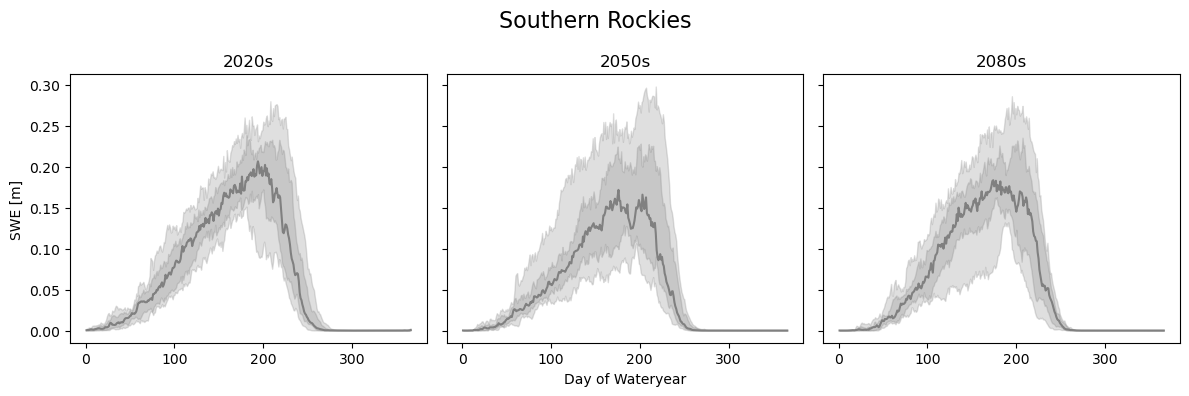

In [10]:
loc = {'lat': slice(38, 40,), 'lon': slice(252-360, 254-360)}
swe_loc_20 = swe_2020s.sel(**loc).mean(dim=['lat', 'lon'])
swe_loc_50 = swe_2050s.sel(**loc).mean(dim=['lat', 'lon'])
swe_loc_80 = swe_2080s.sel(**loc).mean(dim=['lat', 'lon'])

quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)
plot_quantile_spread(swe_loc_20, quantiles, axes[0])
axes[0].set_title('2020s')
plot_quantile_spread(swe_loc_50, quantiles, axes[1])
axes[1].set_title('2050s')
plot_quantile_spread(swe_loc_80, quantiles, axes[2])
axes[2].set_title('2080s')

axes[0].set_ylabel('SWE [m]')
axes[1].set_xlabel('Day of Wateryear')
plt.suptitle('Southern Rockies', fontsize=16)
plt.tight_layout()

In the Northern Cascades, however, we see a much more dramatic decrease even into the 2080s. We also see that the 10th and 90th percentile range has shrunk down, suggesting smaller, but not as variable snowpacks.

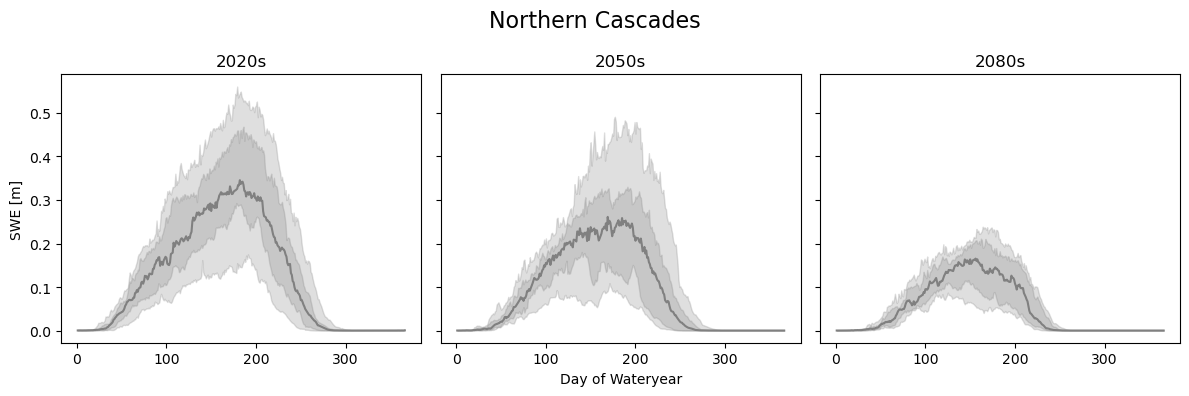

In [11]:
loc = {'lat': slice(47, 49), 'lon': slice(238-360, 240-360), }
swe_loc_20 = swe_2020s.sel(**loc).mean(dim=['lat', 'lon'])
swe_loc_50 = swe_2050s.sel(**loc).mean(dim=['lat', 'lon'])
swe_loc_80 = swe_2080s.sel(**loc).mean(dim=['lat', 'lon'])

fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)
plot_quantile_spread(swe_loc_20, quantiles, axes[0])
axes[0].set_title('2020s')
plot_quantile_spread(swe_loc_50, quantiles, axes[1])
axes[1].set_title('2050s')
plot_quantile_spread(swe_loc_80, quantiles, axes[2])
axes[2].set_title('2080s')

axes[0].set_ylabel('SWE [m]')
axes[1].set_xlabel('Day of Wateryear')
plt.suptitle('Northern Cascades', fontsize=16)
plt.tight_layout()

Finally, the Central Sierra Nevada results show similar trends, but even lower absolute snowpack results. As a reminder, these results should be taken with a grain of salt because they are only a single location, with a single set of GCM, SSP, and downscaling method. To truly assess the future of snow with certainty we will need to look at more combinations.

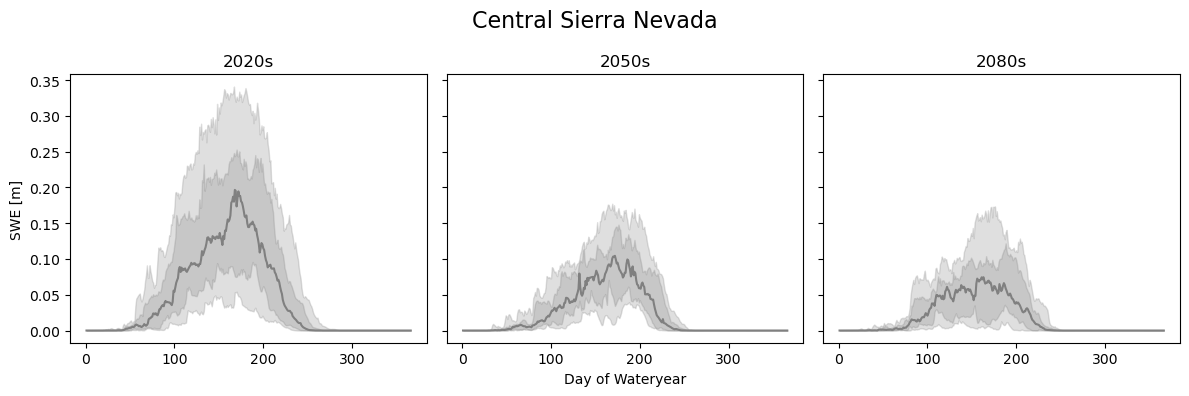

In [12]:
loc = {'lat': slice(37.5, 38.5), 'lon': slice(239.75-360, 240.25-360), }
swe_loc_20 = swe_2020s.sel(**loc).mean(dim=['lat', 'lon'])
swe_loc_50 = swe_2050s.sel(**loc).mean(dim=['lat', 'lon'])
swe_loc_80 = swe_2080s.sel(**loc).mean(dim=['lat', 'lon'])

fig, axes = plt.subplots(1, 3, figsize=(12,4), sharey=True)
plot_quantile_spread(swe_loc_20, quantiles, axes[0])
axes[0].set_title('2020s')
plot_quantile_spread(swe_loc_50, quantiles, axes[1])
axes[1].set_title('2050s')
plot_quantile_spread(swe_loc_80, quantiles, axes[2])
axes[2].set_title('2080s')

axes[0].set_ylabel('SWE [m]')
axes[1].set_xlabel('Day of Wateryear')
plt.suptitle('Central Sierra Nevada', fontsize=16)
plt.tight_layout()

Now that we've seen some temporal results, we can also look at the average snowpack spatially for each of the time periods. Because snow is very seasonally dependent we will look at this only for the winter and spring seasons. 

In [13]:
swe_seas_mean_2020s = swe_2020s.groupby(swe_2020s['time'].dt.season).mean()
swe_seas_mean_2050s = swe_2050s.groupby(swe_2050s['time'].dt.season).mean()
swe_seas_mean_2080s = swe_2080s.groupby(swe_2080s['time'].dt.season).mean()

First we will plot the winter averages, which will show where snow generally is at a maximum in lower-lying areas. Generally, what we see is a reduction in this earlier season snowpack in the lower lying mountains such as the Southern Cascades, and the Basin and Range. We also see a contraction in the area of high-SWE concentration in the larger mountain ranges. Overall, decreases continue more dramatically in the lower lying areas than in the higher areas even into the 2080s.

Text(0.5, 0.98, 'Winter mean SWE [m]')

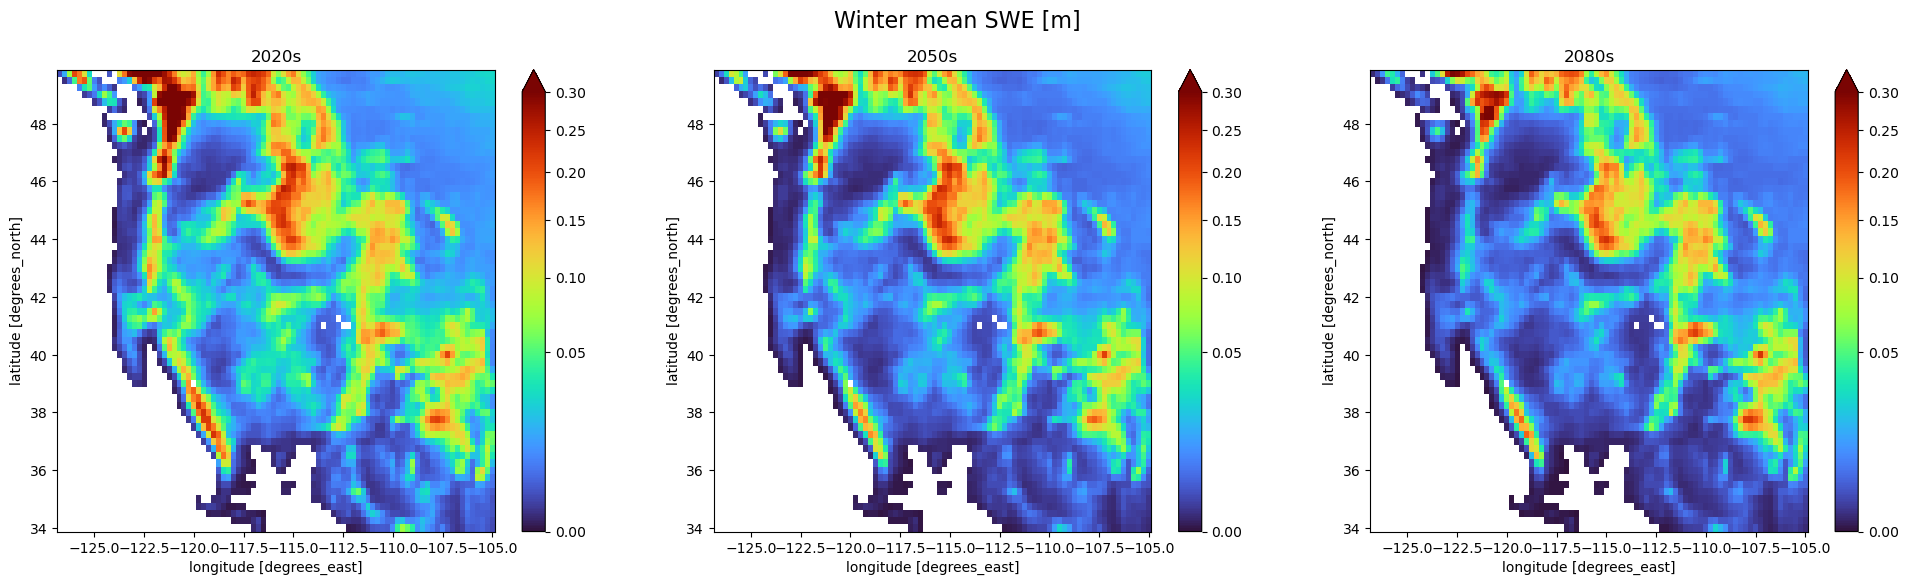

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
norm = PowerNorm(gamma=0.5, vmin=1e-9, vmax=0.3)
swe_seas_mean_2020s.sel(season='DJF').plot(norm=norm, cmap='turbo', ax=axes[0])
swe_seas_mean_2050s.sel(season='DJF').plot(norm=norm, cmap='turbo', ax=axes[1])
swe_seas_mean_2080s.sel(season='DJF').plot(norm=norm, cmap='turbo', ax=axes[2])
axes[0].set_title('2020s')
axes[1].set_title('2050s')
axes[2].set_title('2080s')
plt.suptitle('Winter mean SWE [m]', fontsize=16)

On the other hand, the spring snowpack is generally considered the peak of the season for snow-dominated regions. This time period often is used to estimate the overall carry-over storage that is expected to melt during the generally dry summer-months. Here we can see that there is quite a bit of shrinkage in the snowpack in the Rocky Mountains in Montana and Idaho. There is less dramatic of a decrease in the southern portions of the Rockies in Colorado and New Mexico however. Here we also see a large contraction in the snowpack in the Sierra Nevada and Cascade ranges.

Text(0.5, 0.98, 'Spring mean SWE [m]')

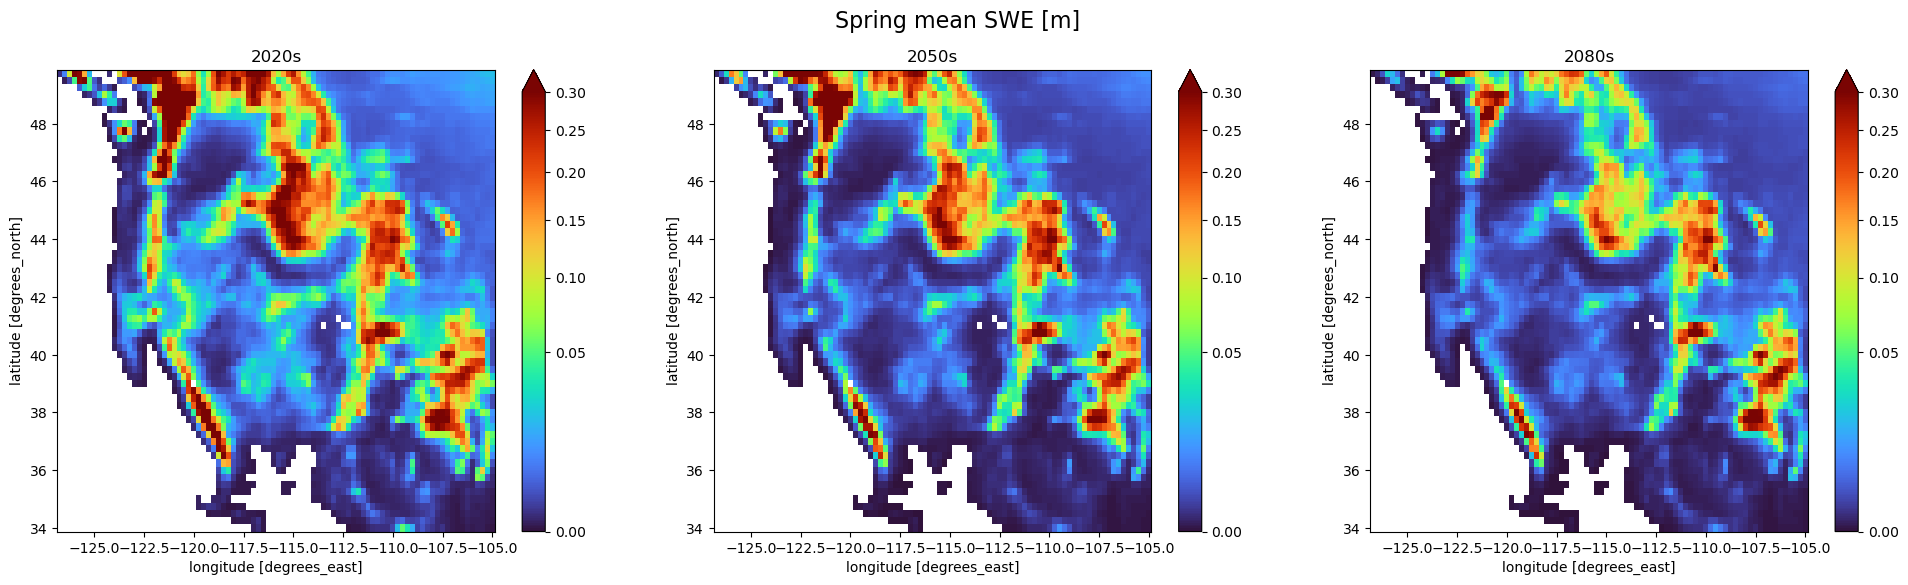

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
swe_seas_mean_2020s.sel(season='MAM').plot(norm=norm, cmap='turbo', ax=axes[0])
swe_seas_mean_2050s.sel(season='MAM').plot(norm=norm, cmap='turbo', ax=axes[1])
swe_seas_mean_2080s.sel(season='MAM').plot(norm=norm, cmap='turbo', ax=axes[2])

axes[0].set_title('2020s')
axes[1].set_title('2050s')
axes[2].set_title('2080s')
plt.suptitle('Spring mean SWE [m]', fontsize=16)

### Conclusions

This is the end of the tutorial, congratulations for making it through. We hope that you have learned some tools and techniques for applying machine learning techniques to large spatiotemporal datasets. We also hope that you can take these techniques and apply them to your data, or expand the scope of our own work here to answer new scientific questions! As mentioned before, this being a tutorial limited the scope and robustness of our results so they should be taken with caution before drawing concrete conclusions. However, you now have the tools to be able to run more robust experiments on this data, so there are some follow ups that you might try:

1) Run the same analysis for a different region. Note region sizes may change and affect the ability to run on free services such as Microsoft Planetary Computer or Google Colab.
2) Train the model for longer or do some hyperparameter tuning. Although our base model worked quite well, there most certainly is still performance to be gained by throwing more resources at the problem.
3) Apply the model to more scenarios to get a sense of uncertainties, or even apply the trained model to a region it wasn't trained on.